# Homework Sequential Learning

## Clemence Grislain

## Part I: Bandit convex optimization

In [ ]:
import numpy as np
from math import*
import random
import matplotlib.pyplot as plt
from tqdm import trange

In [ ]:
d = 2
mean = np.zeros(d)
sigma = np.identity(2)
D = 2
G = 6
T = 1000


def X(d=d):
  return np.random.multivariate_normal(np.zeros(d), np.identity(d), 1).reshape(d)

def Y(x, d=d):
  theta_star = np.array([1/(2*i) for i in range(1,d+1)])

  noise = np.random.normal(0, np.sqrt(0.1), 1)
  return np.dot(theta_star, x) + noise

def loss(theta, x, y):
  return (np.dot(theta,x) - y)**2
  
def grad_loss(theta, x, y):
  return 2 * (np.dot(theta,x) - y) * x

def projection(theta, delta):
    norm_theta = np.linalg.norm(theta)
    # Closest boundary
    if np.abs(1. - norm_theta) < np.abs(1. / (1. - delta) - norm_theta):
      norm_factor = 1.
    else:
      norm_factor = 1. / (1. - delta)
    if norm_theta <= norm_factor:
        # The vector is already inside the space
        return theta
    else:
        # Project the vector onto the boundary of the space
        unit_theta = theta / norm_theta
        projected_theta = unit_theta * norm_factor
        return projected_theta

In [ ]:
def OGD_without(delta, eta, d=d, T=T):
  theta_hat = np.zeros(d)
  theta_star = np.array([1/(2*i) for i in range(1,d+1)]) 
  regrets = []
  for  t in range(T):
    # Draw u_t in S1 uniformally
    u = np.random.normal(0, 1, d)  
    u /= np.linalg.norm(u)
    # Set theta = theta_hat + delta*u
    theta = theta_hat + delta * u
    # Play theta
    x = X(d=d)
    y = Y(x, d=d)
    l = loss(theta, x, y)
    regrets.append(l - loss(theta_star, x, y))
    # Update
    theta_hat = projection(theta_hat - d * eta / delta * l * u, delta)
  return np.cumsum(np.array(regrets))


In [ ]:
def OGD(eta, d=d, T=T):
  theta = np.zeros(d)
  theta_star = np.array([1/(2*i) for i in range(1,d+1)])
  regrets = []
  for t in range(T):
    # Play theta
    x = X(d=d)
    y = Y(x, d=d)
    l = loss(theta, x, y)
    regrets.append(l - loss(theta_star, x, y))
    # Compute gradient
    grad = grad_loss(theta, x, y)
    # Update
    theta = projection(theta - eta * grad, 0.)
  return np.cumsum(np.array(regrets))

In [ ]:
delta = T**(-1/4)*np.sqrt(d * D / (3 * G))
eta = T**(-3/4) * np.sqrt(D / (3 * G * d)) * D
print("OGD without gradient:", " delta", np.round(delta, 4), " eta", np.round(eta, 4))

eta_OGD = D / (G * np.sqrt(T))
print("OGD with gradient:", " eta", np.round(eta_OGD, 4))

OGD without gradient:  delta 0.0838  eta 0.0027
OGD with gradient:  eta 0.0105


In [ ]:
regrets_WITH = OGD(eta_OGD)
regrets_WITHOUT = OGD_without(delta, eta)

C_WITHOUT = np.mean([regrets_WITHOUT[t]/(t**(1/2)) for t in range(10,T)])
C_WITH = np.mean([regrets_WITH[t]/(t**(1/2)) for t in range(10,T)])

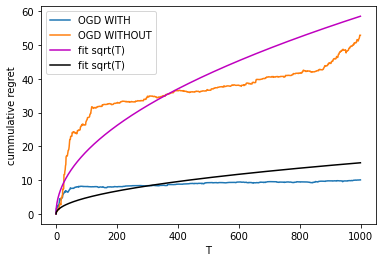

In [ ]:
plt.plot(regrets_WITH, label='OGD WITH')
plt.plot(regrets_WITHOUT, label='OGD WITHOUT')
plt.xlabel("T")
plt.ylabel("cummulative regret")
plt.plot([C_WITHOUT*t**(2/4) for t in range(T)], c='m', label="fit sqrt(T)")
plt.plot([C_WITH*t**(1/2) for t in range(T)], c='black', label="fit sqrt(T)")
plt.legend();

### 7.a) Setting parameter d = 2 

In [ ]:
WITH = []
WITHOUT = []
N = 100

for _ in range(N):
  regrets_WITH = OGD(eta_OGD)
  WITH.append(regrets_WITH)

  regrets_WITHOUT = OGD_without(delta, eta)
  WITHOUT.append(regrets_WITHOUT)

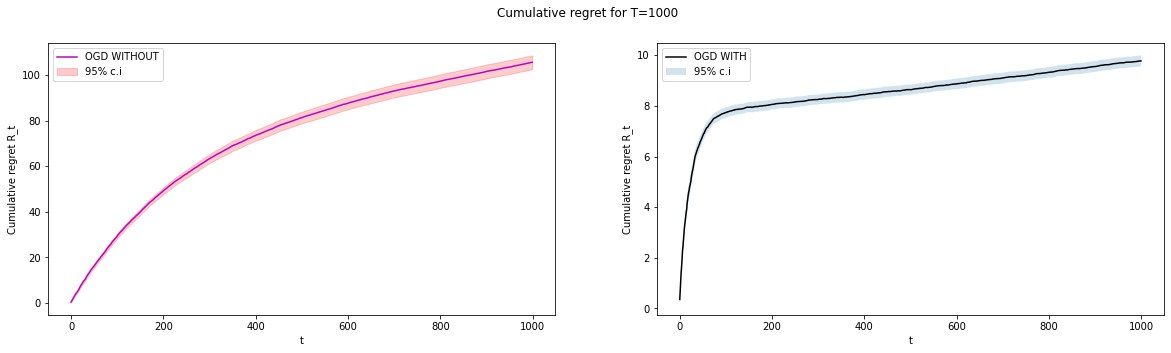

In [ ]:
mean_WITH = np.mean(WITH, axis=0)
std_WITH = np.std(WITH, axis=0)
mean_WITHOUT = np.mean(WITHOUT, axis=0)
std_WITHOUT = np.std(WITHOUT, axis=0)

fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,2,1)
plt.plot(mean_WITHOUT, c='m', label="OGD WITHOUT")
plt.fill_between(np.arange(T), mean_WITHOUT + 1.96*std_WITHOUT/np.sqrt(N), mean_WITHOUT - 1.96*std_WITHOUT/np.sqrt(N), color='red', alpha=0.2, label='95% c.i')
plt.xlabel('t')
plt.ylabel('Cumulative regret R_t')
plt.legend();

fig.add_subplot(1,2,2)
plt.plot(mean_WITH, c='black', label="OGD WITH")
plt.fill_between(np.arange(T), mean_WITH + 1.96*std_WITH/np.sqrt(N), mean_WITH - 1.96*std_WITH/np.sqrt(N), alpha=0.2, label='95% c.i')

plt.xlabel('t')
plt.ylabel('Cumulative regret R_t')
plt.legend();

fig.suptitle(f'Cumulative regret for T={T}');

In [ ]:
WITH = []
WITHOUT = []
N = 100

for T in trange(1,1001):
  res_WITH = []
  res_WITHOUT = []
  for _ in range(N):
    delta = T**(- 1 / 4) * np.sqrt(d * D / (3 * G))
    eta = T**(- 3 / 4) * np.sqrt(D / (3 * G * d)) * D

    eta_OGD = D / (G * np.sqrt(T))

    regrets_WITH = OGD(eta_OGD, d=d, T=T)
    res_WITH.append(regrets_WITH[-1])

    regrets_WITHOUT = OGD_without(delta, eta, d=d, T=T)
    res_WITHOUT.append(regrets_WITHOUT[-1])

  WITH.append(res_WITH)
  WITHOUT.append(res_WITHOUT)

### 7.b) Increasing d


In [ ]:
WITH = []
WITHOUT = []

N = 100
T = 1000

for d in trange(1,11):

  delta = T**(-1/4)*np.sqrt(d*D/(3*G))
  eta = T**(-3/4) * np.sqrt(D/(3*G*d))*D
  #print("OGD without gradient:", " delta", np.round(delta, 4), " eta", np.round(eta, 4))

  eta_OGD = D / (G * np.sqrt(T))
  #print("OGD with gradient:", " eta", np.round(eta_OGD, 4))

  WITH_d = []
  WITHOUT_d = []
  for _ in range(N):
    regrets_WITH = OGD(eta_OGD, d=d)
    WITH_d.append(regrets_WITH[-1])

    regrets_WITHOUT = OGD_without(delta, eta, d=d)
    WITHOUT_d.append(regrets_WITHOUT[-1])
  
  WITH.append(WITH_d)
  WITHOUT.append(WITHOUT_d)

100%|██████████| 10/10 [07:59<00:00, 47.92s/it]


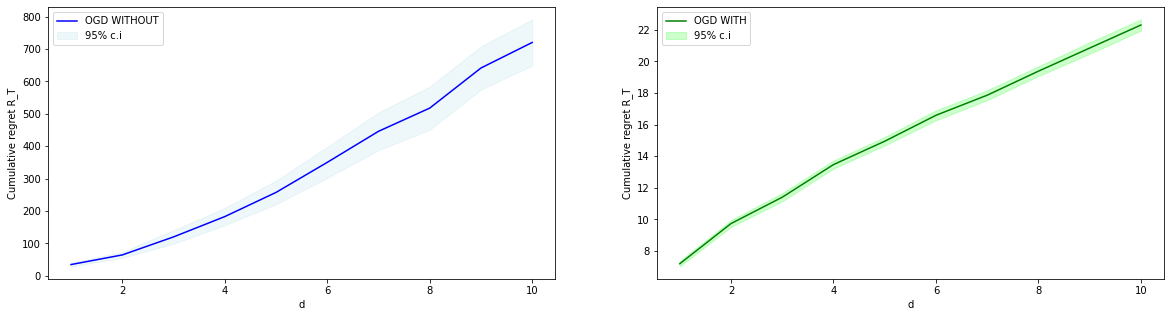

In [ ]:
mean_WITH = []
std_WITH = []
mean_WITHOUT = []
std_WITHOUT = []


for d in range(10):
  mean_WITH_d = np.mean(WITH[d])
  std_WITH_d = np.std(WITH[d])

  mean_WITH.append(mean_WITH_d)
  std_WITH.append(std_WITH_d)

  mean_WITHOUT_d = np.mean(WITHOUT[d])
  std_WITHOUT_d = np.std(WITHOUT[d])

  mean_WITHOUT.append(mean_WITHOUT_d)
  std_WITHOUT.append(std_WITHOUT_d)


fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,2,1)
plt.plot(np.arange(1,11), mean_WITHOUT, c='b', label="OGD WITHOUT")
plt.fill_between(np.arange(1,11), mean_WITHOUT + 1.96*np.array(std_WITHOUT)/np.sqrt(N), mean_WITHOUT - 1.96*np.array(std_WITHOUT)/np.sqrt(N), color='lightBlue', alpha=0.2, label='95% c.i')
plt.xlabel('d')
plt.ylabel('Cumulative regret R_T')
plt.legend();

fig.add_subplot(1,2,2)
plt.plot(np.arange(1,11), mean_WITH, c='g', label="OGD WITH")
plt.fill_between(np.arange(1,11), mean_WITH + 1.96 * np.array(std_WITH)/np.sqrt(N), mean_WITH - 1.96 * np.array(std_WITH)/np.sqrt(N), color="lime", alpha=0.2, label='95% c.i')

plt.xlabel('d')
plt.ylabel('Cumulative regret R_T')
plt.legend();

## Part 2 : Stochastic Best Arm Identification

In [ ]:
K = 20
means = np.array([0.5] + [0.4]*(K-1))

log_K = 1/2 + np.sum([1/k for k in range(2,K+1)])

def n(j, T):
  if j==0:
    return 0
  return ceil(1/log_K * (T-K)/(K+1-j))

def uniform_sampling(T):
  empirical_mean = np.zeros(K)
  N = int(T/K)
  for k in range(K):
    for _ in range(N):
      dice = np.random.uniform()
      empirical_mean[k] += (dice <= means[k]) / N
  return np.argmax(empirical_mean) + 1, empirical_mean

def successive_rejects(T):
  A = set([k for k in range(1,K+1)])
  scores = np.zeros(K)
  for j in range(1, K):
    N = n(j, T) - n(j-1, T)
    idx = []
    for i in A:
      score = 0
      for _ in range(N):
        dice = np.random.uniform()
        score += (dice <= means[i-1])

      scores[i-1] += score
      idx.append(i)

    idx = np.array(idx)
    argmins = idx[np.where(scores[idx-1] == np.min(scores[idx-1]))[0]]
    argmin = argmins[np.random.randint(0,len(argmins))]

    A.remove(argmin)
  return A

In [ ]:
SJ = []
U  = []
N = 10000

for T in [100, 500, 2000]:
  error_reject = 0
  error_uniform = 0
  for _ in trange(N):
    error_reject += successive_rejects(T) != {1}
    error_uniform += uniform_sampling(T)[0] != 1
  SJ.append(error_reject/N)
  U.append(error_uniform/N)

100%|██████████| 10000/10000 [05:28<00:00, 30.45it/s]


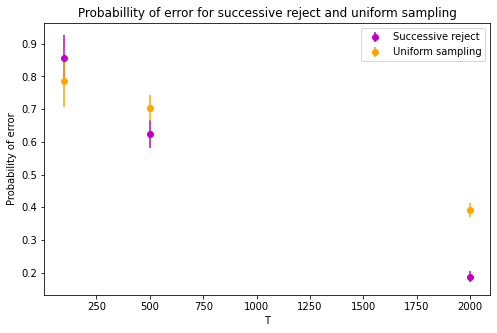

In [ ]:
fig = plt.figure(figsize=(8,5))

SJ_std = [1.96 * np.sqrt(SJ[i]*(1. - SJ[i]))/ np.sqrt(T) for i,T in enumerate([100,500,2000])]
plt.errorbar([100,500,2000], SJ, yerr=SJ_std, label="Successive reject", fmt="o", c='m')

U_std = [1.96 * np.sqrt(U[i]*(1. - U[i]))/ np.sqrt(T) for i,T in enumerate([100,500,2000])]
plt.errorbar([100,500,2000], U, yerr=U_std, label="Uniform sampling", fmt="o", c='orange')

plt.legend()
plt.xlabel("T")
plt.ylabel("Probability of error")
plt.title("Probabillity of error for successive reject and uniform sampling");

### Fixed confidence

In [ ]:
K = 10

means = [0.5, 0.4, 0.4] + [0.3]*(K-3)
var = 1.
delta = 0.01

1.a)

In [ ]:
def get_UCB(scores, N, t):
  return np.argmax(scores / N + np.sqrt(2 * np.log(t) / N))

def UCB_T(T):
  scores = np.zeros(K)
  N = np.zeros(K)
  regrets = []

  for k in range(K):
    N[k] += 1
    scores[k] += np.random.normal(means[k], np.sqrt(var), 1)
    regrets.append(means[0] - means[k])
    
  for t in range(K+1,T):
    k_t = get_UCB(scores, N, t)
    N[k_t] += 1
    scores[k_t] += np.random.normal(means[k_t], np.sqrt(var), 1)
    regrets.append(means[0] - means[k_t])
    
  return np.argmax(N), np.cumsum(regrets)


In [ ]:
T = 10000
runs = 100
UCB_regrets = []
for _ in trange(runs):
  _, cum_regrets = UCB_T(T)
  UCB_regrets.append(cum_regrets)

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


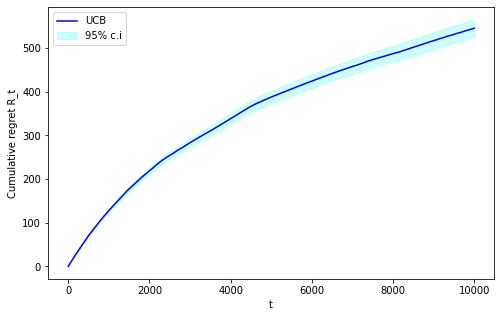

In [ ]:
fig = plt.figure(figsize=(8,5))

UCB_mean = np.mean(UCB_regrets, axis=0)
UCB_std = np.std(UCB_regrets, axis=0)

plt.plot(np.arange(1,T), UCB_mean, c='b', label="UCB")
plt.fill_between(np.arange(1,T), UCB_mean + 1.96*np.array(UCB_std)/np.sqrt(runs), UCB_mean - 1.96*np.array(UCB_std)/np.sqrt(runs), color='cyan', alpha=0.2, label='95% c.i')
plt.xlabel('t')
plt.ylabel('Cumulative regret R_t')
plt.legend();

1.b)

In [ ]:
def stopping_rule(scores, N, t, display=False):
  best_k = np.argmax(scores / N)
  best_N = N[best_k]
  inf = np.min([0.5 *(scores[best_k] / best_N - scores[k] / N[k])**2 / (1 / N[k] + 1 / best_N) for k in range(K) if k != best_k])

  if display:
    print(inf, np.log(1. / delta) + 3 * np.log(1 + np.log(t)))
    
  return inf > np.log(1. / delta) + 3 * np.log(1 + np.log(t))

def UCB():
  t = 0
  scores = np.zeros(K)
  N = np.zeros(K)

  for k in range(K):
    N[k] += 1
    scores[k] += np.random.normal(means[k], np.sqrt(var), 1)
    t += 1

  while not stopping_rule(scores, N, t):
    k_t = get_UCB(scores, N, t)
    N[k_t] += 1
    scores[k_t] += np.random.normal(means[k_t], np.sqrt(var), 1)
    t += 1
   
  return np.argmax(N), t


def uniform():
  t = 0
  scores = np.zeros(K)
  N = np.zeros(K)
  
  for k in range(K):
    N[k] += 1
    scores[k] += np.random.normal(means[k], np.sqrt(var), 1)
    t += 1
  
  while not stopping_rule(scores, N, t):
    k_t = np.random.randint(0, K)
    N[k_t] += 1
    scores[k_t] += np.random.normal(means[k_t], np.sqrt(var), 1)
    t += 1

  return np.argmax(scores / N), t

In [ ]:
runs = 50
UCB_stop = []
Uni_stop = []
for _ in trange(runs):
  _, UCB_tau = UCB()
  UCB_stop.append(UCB_tau)
  _, Uni_tau = uniform()
  Uni_stop.append(Uni_tau)

100%|██████████| 50/50 [1:02:51<00:00, 75.42s/it]


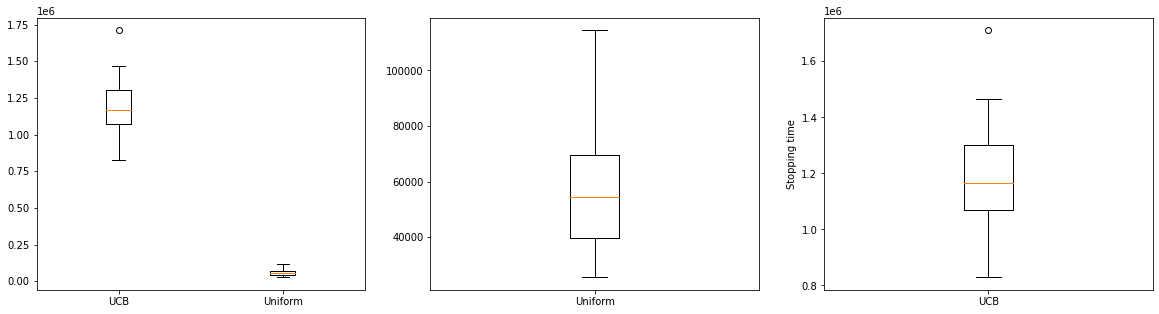

In [ ]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.boxplot([UCB_stop, Uni_stop], vert=True, labels=['UCB', 'Uniform'])

fig.add_subplot(1,3,2)
plt.boxplot([Uni_stop], vert=True, labels=['Uniform'])

fig.add_subplot(1,3,3)
plt.boxplot([UCB_stop], vert=True, labels=['UCB'])
plt.ylabel("Stopping time");


2.

In [ ]:
beta = 0.5
var = 1.

def Challenger(scores, N, B_t):
  values = [0.5 * (scores[B_t] / N[B_t] - scores[k] / N[k])**2 / (1 / N[B_t] + 1 / N[k]) for k in range(K) if k != B_t]
  candidates = [k for k in range(K) if k != B_t]
  return candidates[np.argmin(values)]

def TTUCB():
  t = 0
  scores = np.zeros(K)
  N = np.zeros(K)
  # Play once all the arms
  for k in range(K):
    N[k] += 1
    scores[k] += np.random.normal(means[k], np.sqrt(var), 1)
    t += 1

  while not stopping_rule(scores, N, t):
    B_t = get_UCB(scores, N, t)
    C_t = Challenger(scores, N, B_t)
    # Choose UCB with proba beta
    if np.random.uniform() > beta:
      k_t = B_t
    else:
      k_t = C_t
    # Play k_t
    scores[k_t] += np.random.normal(means[k_t], np.sqrt(var), 1)
    N[k_t] += 1
    t += 1

  return np.argmax(scores / N), t

def EB_TC():
  t = 0
  scores = np.zeros(K)
  N = np.zeros(K)
  # Play once all the arms
  for k in range(K):
    N[k] += 1
    scores[k] += np.random.normal(means[k], 1)
    t += 1

  while not stopping_rule(scores, N, t):
    B_t = np.argmax(scores / N)
    C_t = Challenger(scores, N, B_t)
    # Choose UCB with proba beta
    if np.random.binomial(1, beta):
      k_t = B_t
    else:
      k_t = C_t
    # Play k_t
    scores[k_t] += np.random.normal(means[k_t], 1)
    N[k_t] += 1
    t += 1

    if t > 100000:
      # Stop infinte loop
      return np.argmax(scores / N), t

  return np.argmax(scores / N), t

In [ ]:
runs = 50
TTUCB_stop = []
EB_TC_stop = []
for _ in trange(runs):
  _, TTUCB_tau = TTUCB()
  TTUCB_stop.append(TTUCB_tau)
  _, EB_TC_tau = EB_TC()
  EB_TC_stop.append(EB_TC_tau)

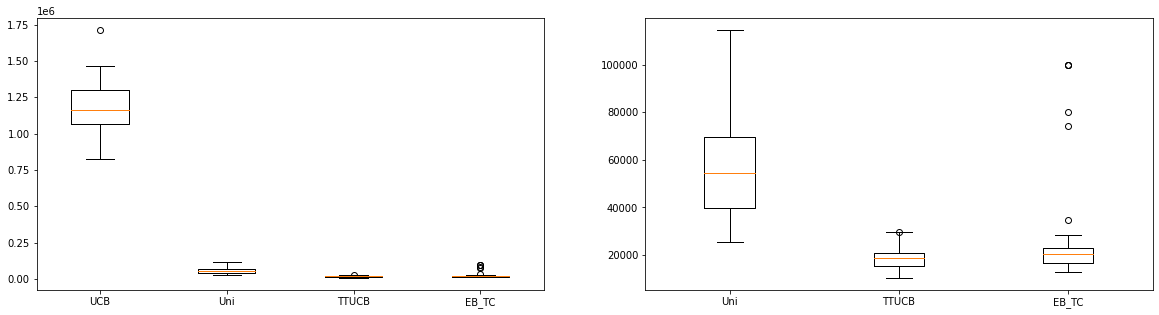

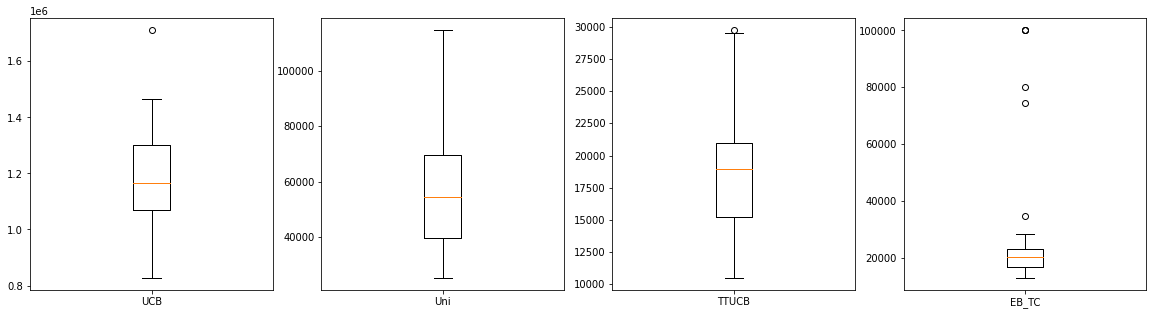

In [ ]:
fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1,2,1)
plt.boxplot([UCB_stop, Uni_stop, TTUCB_stop, EB_TC_stop], labels=["UCB", "Uni", "TTUCB", "EB_TC"])

fig.add_subplot(1,2,2)
plt.boxplot([Uni_stop, TTUCB_stop, EB_TC_stop], labels=["Uni", "TTUCB", "EB_TC"])


fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1,4,1)
plt.boxplot([UCB_stop], labels=["UCB"])


fig.add_subplot(1,4,2)
plt.boxplot([Uni_stop], labels=["Uni"])


fig.add_subplot(1,4,3)
plt.boxplot([TTUCB_stop], labels=["TTUCB"])


fig.add_subplot(1,4,4)
plt.boxplot([EB_TC_stop], labels=["EB_TC"]);
